# 第六章 &nbsp; &nbsp; Gated RNN 
上一章的 RNN 存在环路，可以记忆过去的信息，其结构非常简单，易于实现。不过，遗憾的是，这个 RNN 的效果并不好。原因在于，许多情况下它都无法很好地学习到时序数据的长期依赖关系。

现在，上一章的简单 RNN 经常被名为 LSTM 或 GRU 的层所代替。实际上，当我们说 RNN 时，更多的是指 LSTM 层，而不是上一章的 RNN。顺便说一句，当需要明确指上一章的 RNN 时，我们会说“简单 RNN”或 “Elman”。

LSTM 和 GRU 中增加了一种名为“门”的结构。基于这个门，可以学习到时序数据的长期依赖关系。本章我们将指出上一章的 RNN 的问题，介绍代替它的 LSTM 和 GRU 等 “Gated RNN”。特别是我们将花很多时间研究 LSTM 的结构，并揭示它实现 “长期记忆” 的机制。此外，我们将使用 LSTM 创建语言模型，并展示它可以在实际数据上很好地学习。

## RNN的问题
上一章介绍的 RNN 之所以不擅长学习时序数据的长期依赖关系，是因为 BPTT 会发生梯度消失和梯度爆炸的问题。本节我们将首先回顾一下上一章介绍的 RNN 层，并通过一个实际的例子来说明为什么 RNN 层不擅长长期记忆。

---

RNN（循环神经网络）的"记忆是短期的"主要源于其结构设计导致的**梯度消失或梯度爆炸问题**，这使得它难以捕捉长序列中的长期依赖关系，具体原因如下：

1. **信息传递的衰减特性**  
   RNN通过循环结构将前一时刻的隐藏状态传递到当前时刻，公式可简化为：  
   $$
    h_t = \sigma(W_h h_{t-1} + W_x x_t + b) 
   $$ 
   其中 $ h_t $ 是当前隐藏状态，$ h_{t-1} $ 是前一时刻的状态。  
   当序列较长时，早期信息需要通过多个时间步的矩阵乘法传递，类似于"链式相乘"。若权重矩阵的特征值小于1，多次相乘后会导致梯度逐渐趋近于0（梯度消失）；若大于1，则会导致梯度急剧增大（梯度爆炸）。  
   这两种情况都会使模型难以学习到早期信息与后期输出的关联，仿佛"记不住信息随着时间衰减"。

2. **无法主动保留重要信息**  
   RNN没有机制主动筛选和保留关键信息，所有历史信息都会被同等处理并逐步传递。随着序列长度增加，早期信息会被不断涌入的新信息"稀释"，最终几乎无法影响后期的预测。  
   例如，在处理一句话时，RNN可能很快忘记句首的主语，导致后续动词的单复数预测错误。

3. **实际表现的局限性**  
   在实践中，RNN能有效捕捉的依赖关系通常局限在几十个时间步内。对于更长的序列（如段落级文本、长视频帧），早期信息几乎会完全丢失，因此被认为只能保留"短期记忆"。

相比之下，LSTM通过门控机制（遗忘门、输入门、输出门）主动控制信息的保留与丢弃，解决了梯度消失问题，从而能够学习到更长序列的依赖关系，具备"长期记忆"能力。

---

### RNN的复习
RNN 层存在环路。如果展开它的循环，它将变成一个在水平方向上延伸的网络，如下图所示。

<img src="./fig/RNN_unfold.png" alt="RNN_unfold" style="display: block; margin: 0 auto;">

在图中，当输入时序数据 $\boldsymbol{x}_t$ 时，RNN 层输出 $\boldsymbol{h}_t$。这个 $\boldsymbol{h}_t$ 也称为 RNN 层的隐藏状态，它记录过去的信息。

RNN 的特点在于使用了上一时刻的隐藏状态，由此，RNN 可以继承过去的信息。顺便说一下，如果用计算图来表示此时 RNN 层进行的处理，则有下图。

<img src="./fig/RNN_calculation.png" alt="RNN_calculation" style="display: block; margin: 0 auto;">

如图所示，RNN 层的正向传播进行的计算由矩阵乘积、矩阵加法和基于激活函数 $\tanh$ 的变换构成，这就是我们上一章看到的 RNN 层。下面，我们看一下这个 RNN 层存在的问题（关于长期记忆的问题）。

## 梯度消失和梯度爆炸
语言模型的任务是根据已经出现的单词预测下一个将要出现的单词。上一章我们实现了基于 RNN 的语言模型 RNNLM，这里借着探讨 RNNLM 问题的机会，我们再来考虑一下图所示的任务。

<img src="./fig/long_memory.png" alt="long_memory" style="display: block; margin: 0 auto;">

如前所述，填入 “?” 中的单词应该是 Tom。要正确回答这个问题，RNNLM 需要记住 “Tom 在房间看电视，Mary 进了房间” 这些信息。这些信息必须被编码并保存在 RNN 层的隐藏状态中。

现在让我们站在 RNNLM 进行学习的角度来考虑上述问题。在正确解标签为 Tom 时，RNNLM 中的梯度是如何传播的呢？这里我们使用 BPTT 进行学习，因此梯度将从正确解标签 Tom 出现的地方向过去的方向传播，如下图所示。

<img src="./fig/flow.png" alt="flow" style="display: block; margin: 0 auto;">

在学习正确解标签 Tom 时，重要的是 RNN 层的存在。RNN 层通过向过去传递“有意义的梯度”，能够学习时间方向上的依赖关系。此时梯度（理论上）包含了那些应该学到的有意义的信息，通过将这些信息向过去传递，RNN 层学习长期的依赖关系。但是，如果这个梯度在中途变弱（甚至没有包含任何信息），则权重参数将不会被更新。也就是说，RNN 层无法学习长期的依赖关系。不幸的是，随着时间的回溯，这个简单 RNN 未能避免梯度变小（梯度消失）或者梯度变大（梯度爆炸）的命运。

## 梯度消失和梯度爆炸的原因
现在，我们深挖一下 RNN 层中梯度消失（或者梯度爆炸）的起因。如下图所示，这里仅关注 RNN 层在时间方向上的梯度传播。

<img src="./fig/RNN_time_gradient.png" alt="RNN_time_gradient" style="display: block; margin: 0 auto;">

如图所示，这里考虑长度为 $T$ 的时序数据，关注从第 $T$ 个正确解标签传递出的梯度如何变化。就上面的问题来说，这相当于第 $T$ 个正确解标签是 Tom 的情形。此时，关注时间方向上的梯度，可知反向传播的梯度流经 $\tanh$、“$+$”和 MatMul（矩阵乘积）运算。

“$+$”的反向传播将上游传来的梯度原样传给下游，因此梯度的值不变。那么，剩下的 $\tanh$ 和 MatMul 运算会怎样变化呢？我们先来看一下 $\tanh$。

当 $y = \tanh(x)$ 时，它的导数是 $\frac{\mathrm{d}y}{\mathrm{d}x} = 1 - y^2$。此时，将 $y = \tanh(x)$ 的值及其导数的值分别画在图上，如图所示。

<img src="./fig/tanhx.png" alt="tanhx" style="display: block; margin: 0 auto;">

图中的虚线是 $y = \tanh(x)$ 的导数。从图中可以看出，它的值小于 1.0，并且随着 $x$ 远离 0，它的值在变小。这意味着，当反向传播的梯度经过 $\tanh$ 节点时，它的值会越来越小。因此，如果经过 $\tanh$ 函数 $T$ 次，则梯度也会减小 $T$ 次。

RNN 层的激活函数一般使用 $\tanh$ 函数，但是如果改为 ReLU 函数，则有希望抑制梯度消失的问题（当 ReLU 的输入为 $x$ 时，它的输出是 $\max(0, x)$）。这是因为，在 ReLU 的情况下，当 $x$ 大于 0 时，反向传播将上游的梯度原样传递到下游，梯度不会 “退化”。实际上，题为 “Improving performance of recurrent neural network with relu nonlinearity” 的论文就使用 ReLU 实现了性能改善。

接下来，我们关注 MatMul（矩阵乘积）节点。简单起见，这里我们忽略 $\tanh$ 节点。如此一来，如下图所示，RNN 层的反向传播的梯度就仅取决于 MatMul 运算。

<img src="./fig/RNN_propagation.png" alt="RNN_propagation" style="display: block; margin: 0 auto;">

在图中，假定从上游传来梯度 $\mathrm{d}\boldsymbol{h}$，此时 MatMul 节点的反向传播通过矩阵乘积 $\mathrm{d}\boldsymbol{h}\boldsymbol{W}_h^\mathrm{T}$ 计算梯度。之后，根据时序数据的时间步长，将这个计算重复相应次数。这里需要注意的是，每一次矩阵乘积计算都使用相同的权重 $\boldsymbol{W}_h$。

那么，反向传播时梯度的值通过 MatMul 节点时会如何变化呢？一旦有了疑问，最好的方法就是做实验！让我们通过下面的代码，来观察梯度大小的变化。

[2.4684068094579303, 3.335704974161037, 4.783279375373183, 6.2795873320876145, 8.080776465019055, 10.25116303229294, 12.9360635066099, 16.276861327786712, 20.454829618345983, 25.688972842084684, 32.25315718048336, 40.48895641683869, 50.824407307019094, 63.79612654485427, 80.07737014308985, 100.51298922051251, 126.16331847536827, 158.3592064825883, 198.77107967611957, 249.495615421267]


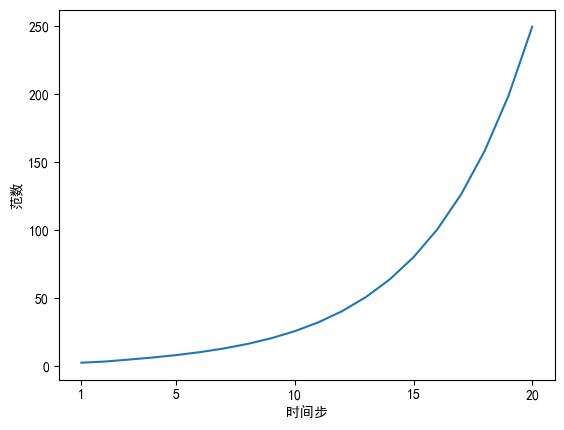

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文黑体
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号

N = 2  # mini-batch的大小
H = 3  # 隐藏状态向量的维数
T = 20  # 时序数据的长度

dh = np.ones((N, H)) # 来自上游的梯度，初始值设为1

np.random.seed(3) # 保持结果的可复现性

Wh = np.random.randn(H, H) # 权重矩阵
#Wh = np.random.randn(H, H) * 0.5

norm_list = []
for t in range(T):
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

print(norm_list) 

# 绘制图形
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20]) # 设置x轴刻度
plt.xlabel('时间步')
plt.ylabel('范数')
plt.show()


这里用 `np.ones()` 初始化 `dh`（`np.ones()` 是所有元素均为 1 的矩阵）。然后，根据反向传播的 MatMul 节点的数量更新 `dh` 相应次数，并将各步的 `dh` 的大小（范数）添加到 `norm_list` 中。这里，`dh` 的大小是 mini-batch（$N$ 笔）中的平均 “L2 范数”。L2 范数对所有元素的平方和求平方根。

下面，我们将上述代码的执行结果（`norm_list`）画在图上，如下图所示。

<img src="./fig/gradient_grow.png" alt="gradient_grow" style="display: block; margin: 0 auto;">

如图所示，可知梯度的大小随时间步长呈指数级增加，这就是梯度爆炸（exploding gradients）。如果发生梯度爆炸，最终就会导致溢出，出现 NaN（Not a Number，非数值）之类的值。如此一来，神经网络的学习将无法正确运行。

现在做第 2 个实验，将 `Wh` 的初始值改为下面的值。

```python
# Wh = np.random.randn(H, H)    # 之前
Wh = np.random.randn(H, H) * 0.5  # 现在
```

[1.2342034047289652, 0.8339262435402592, 0.5979099219216478, 0.3924742082554759, 0.25252426453184545, 0.16017442237957719, 0.10106299614538984, 0.06358148956166684, 0.039950839098332, 0.025086887541098325, 0.015748611904532892, 0.009884999125204758, 0.006204151282595104, 0.003893806551809953, 0.002443767399386287, 0.0015337065005571367, 0.0009625497320203268, 0.0006040924319556743, 0.00037912574706291117, 0.00023793756048323344]


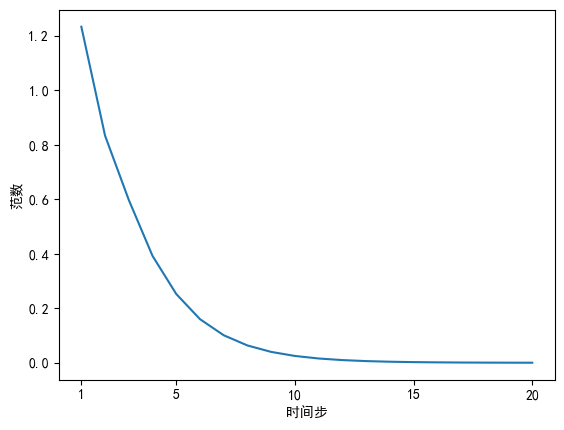

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文黑体
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号

N = 2  # mini-batch的大小
H = 3  # 隐藏状态向量的维数
T = 20  # 时序数据的长度

dh = np.ones((N, H)) # 来自上游的梯度，初始值设为1

np.random.seed(3) # 保持结果的可复现性

# Wh = np.random.randn(H, H) 
Wh = np.random.randn(H, H) * 0.5 # 权重矩阵

norm_list = []
for t in range(T):
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

print(norm_list) 

# 绘制图形
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20]) # 设置x轴刻度
plt.xlabel('时间步')
plt.ylabel('范数')
plt.show()

使用这个初始值，进行与上面相同的实验，结果如下图所示。

<img src="./fig/gradient_descent.png" alt="gradient_descent" style="display: block; margin: 0 auto;">

从图中可以看出，这次梯度呈指数级减小，这就是**梯度消失**（vanishing gradients）。如果发生梯度消失，梯度将迅速变小。一旦梯度变小，权重梯度不能被更新，模型就会无法学习长期的依赖关系。

在这里进行的实验中，梯度的大小或者呈指数级增加，或者呈指数级减小。为什么会出现这样的指数级变化呢？因为矩阵 `Wh` 被反复乘了 $T$ 次。如果 `Wh` 是标量，则问题将很简单：当 `Wh` 大于 1 时，梯度呈指数级增加；当 `Wh` 小于 1 时，梯度呈指数级减小。

那么，如果 `Wh` 不是标量，而是矩阵呢？此时，矩阵的奇异值将成为指标。简单而言，矩阵的奇异值表示数据的离散程度。根据这个奇异值（更准确地说是多个奇异值中的最大值）是否大于 1，可以预测梯度大小的变化。

如果奇异值的最大值大于1，则可以预测梯度很有可能会呈指数级增加；而如果奇异值的最大值小于1，则可以判断梯度会呈指数级减小。但是，并不是说奇异值比1大就一定会出现梯度爆炸。也就是说，这是必要条件，并非充分条件。

## 梯度爆炸的对策
至此，我们探讨了 RNN 的梯度爆炸和梯度消失问题，现在我们继续讨论解决方案。首先来看一下梯度爆炸。

解决梯度爆炸有既定的方法，称为**梯度裁剪**（gradients clipping）。这是一个非常简单的方法，它的伪代码如下所示：

$$
\begin{align*}
\text{if } &\|\hat{\boldsymbol{g}}\| \geqslant \text{threshold}: \\
&\hat{\boldsymbol{g}} = \frac{\text{threshold}}{\|\hat{\boldsymbol{g}}\|} \hat{\boldsymbol{g}}
\end{align*}
$$

这里假设可以将神经网络用到的所有参数的梯度整合成一个，并用符号 $\hat{\boldsymbol{g}}$ 表示。另外，将阈值设置为 $\text{threshold}$。此时，如果梯度的 L2 范数 $\|\hat{\boldsymbol{g}}\|$ 大于或等于阈值，就按上述方法修正梯度，这就是梯度裁剪。如你所见，虽然这个方法很简单，但是在许多情况下效果都不错。

$\hat{\boldsymbol{g}}$ 整合了神经网络中用到的所有参数的梯度。比如，当某个模型有 $\boldsymbol{W}_1$ 和 $\boldsymbol{W}_2$ 两个参数时，$\hat{\boldsymbol{g}}$ 就是这两个参数对应的梯度 $\mathrm{d}\boldsymbol{W}_1$ 和 $\mathrm{d}\boldsymbol{W}_2$ 的组合。

现在，我们用 Python 来实现梯度裁剪，将其实现为 `clip_grads(grads, max_norm)` 函数。参数 `grads` 是梯度的列表，`max_norm` 是阈值，此时梯度裁剪可以如下实现。

In [3]:
import numpy as np


dW1 = np.random.rand(3, 3) * 10 # 生成一个3x3的随机矩阵，值在0到10之间
dW2 = np.random.rand(3, 3) * 10 # 生成另一个3x3的随机矩阵，值在0到10之间
grads = [dW1, dW2] # 假设有两个参数的梯度
max_norm = 5.0 # 设置梯度裁剪的阈值

# 定义梯度裁剪函数
def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm) # 计算总的L2范数

    rate = max_norm / (total_norm + 1e-6) # 计算裁剪比例
    if rate < 1: # 只有当总范数超过阈值时才进行裁剪
        for grad in grads:
            grad *= rate


print('之前:', dW1.flatten()) 
clip_grads(grads, max_norm)
print('现在:', dW1.flatten())

之前: [6.49144048 2.78487283 6.76254902 5.90862817 0.23981882 5.58854088
 2.59252447 4.15101197 2.83525082]
现在: [1.49503731 0.64138134 1.55747605 1.36081038 0.05523244 1.28709139
 0.59708178 0.95601551 0.65298384]


这就是梯度裁剪的实现，并没有什么特别难的地方。因为将来还会用到 `clip_grads(grads, max_norm)`，所以我们在 `common/util.py` 中也放了一份相同的代码。

本书提供了用于RNNLM学习的<code>RnnlmTrainer</code>类（<code>common/trainer.py</code>），它的内部利用了上述梯度裁剪以防止梯度爆炸。我们会在之后的小节再次说明<code>RnnlmTrainer</code>类中的梯度裁剪。

以上就是对梯度裁剪的说明。下面，我们看一下防止梯度消失的对策。

## 梯度消失和LSTM
在 RNN 的学习中，梯度消失也是一个大问题。为了解决这个问题，需要从根本上改变 RNN 层的结构，这里本章的主题 Gated RNN 就要登场了。

人们已经提出了诸多 Gated RNN 框架（网络结构），其中具有代表性的有 LSTM 和 GRU。本节我们将关注 LSTM，仔细研究它的结构，并阐明为何它不会（难以）引起梯度消失。

## LSTM的接口
接下来，我们仔细看一下 LSTM 层。在此之前，为了将来方便，我们在计算图中引入“简略图示法”。如下图所示，这种图示法将矩阵计算等整理为一个长方形节点。

<img src="./fig/simple_RNN.png" alt="simple_RNN" style="display: block; margin: 0 auto;">

如图所示，这里将 $\tanh(\boldsymbol{h}_{t-1}\boldsymbol{W}_h + \boldsymbol{x}_t\boldsymbol{W}_x + \boldsymbol{b})$ 这个计算表示为一个长方形节点 $\tanh$（$\boldsymbol{h}_{t-1}$ 和 $\boldsymbol{x}_t$ 是行向量），这个长方形节点中包含了矩阵乘积、偏置的和以及基于 $\tanh$ 函数的变换。

现在我们已经做好了准备。首先，我们来比较一下 LSTM 与 RNN 的接口（输入和输出）。

<img src="./fig/RNN_vs_LSTM.png" alt="RNN_vs_LSTM" style="display: block; margin: 0 auto;">

如图所示，LSTM 与 RNN 的接口的不同之处在于，LSTM 还有路径 $\boldsymbol{c}$。这个 $\boldsymbol{c}$ 称为记忆单元（或者简称为“单元”），相当于 LSTM 专用的记忆部门。

记忆单元的特点是，仅在 LSTM 层内部接收和传递数据。也就是说，记忆单元在 LSTM 层内部结束工作，不向其他层输出。而 LSTM 的隐藏状态 $\boldsymbol{h}$ 和 RNN 层相同，会被（向上）输出到其他层。

从接收LSTM的输出的一侧来看，LSTM的输出仅有隐藏状态向量 $\boldsymbol{h}$。记忆单元 $\boldsymbol{c}$ 对外部不可见，我们甚至不用考虑它的存在。

## LSTM层的结构
现在，我们来看一下 LSTM 层的内部结构。这里，我想一个一个地组装 LSTM 的部件，并仔细研究它们的结构。以下内容参考了 “colah’s blog: Understanding LSTM Networks” 这篇优秀的文章。

如前所述，LSTM 有记忆单元 $\boldsymbol{c}_t$。这个 $\boldsymbol{c}_t$ 存储了时刻 $t$ 时 LSTM 的记忆，可以认为其中保存了从过去到时刻 $t$ 的所有必要信息（或者以此为目的进行了学习）。然后，基于这个充满必要信息的记忆，向外部的层（和下一时刻的 LSTM）输出隐藏状态 $\boldsymbol{h}_t$。如图所示，LSTM 输出经 $\tanh$ 函数变换后的记忆单元。

<img src="./fig/LSTM_memory.png" alt="LSTM_memory" style="display: block; margin: 0 auto;">

如图所示，当前的记忆单元 $\boldsymbol{c}_t$ 是基于 3 个输入 $\boldsymbol{c}_{t-1}$、$\boldsymbol{h}_{t-1}$ 和 $\boldsymbol{x}_t$，经过“某种计算”（后述）算出来的。这里的重点是隐藏状态 $\boldsymbol{h}_t$ 要使用更新后的 $\boldsymbol{c}_t$ 来计算。另外，这个计算是 $\boldsymbol{h}_t = \tanh(\boldsymbol{c}_t)$，表示对 $\boldsymbol{c}_t$ 的各个元素应用 $\tanh$ 函数。

到目前为止，记忆单元 $\boldsymbol{c}_t$ 和隐藏状态 $\boldsymbol{h}_t$ 的关系只是按元素应用 $\tanh$ 函数。这意味着，记忆单元 $\boldsymbol{c}_t$ 和隐藏状态 $\boldsymbol{h}_t$ 的元素个数相同。如果记忆单元 $\boldsymbol{c}_t$ 的元素个数是 100，则隐藏状态 $\boldsymbol{h}_t$ 的元素个数也是 100。

在进入下一项之前，我们先简单说明一下 Gate 的功能。Gate 是“门”的意思，就像将门打开或合上一样，控制数据的流动。直观上，如下图所示，门的作用就是阻止或者释放水流。

<img src="./fig/gate.png" alt="gate" style="display: block; margin: 0 auto;">

LSTM 中使用的门并非只能“开或合”，还可以根据将门打开多少来控制水的流量。如下图所示，可以将“开合程度”控制在 0.7（70%）或者 0.2（20%）。

<img src="./fig/gate_control.png" alt="gate_control" style="display: block; margin: 0 auto;">

如图所示，门的开合程度由 0.0~1.0 的实数表示（1.0 为全开），通过这个数值控制流出的水量。这里的重点是，门的开合程度也是（自动）从数据中学习到的。

有专门的权重参数用于控制门的开合程度，这些权重参数通过学习被更新。另外，sigmoid函数用于求门的开合程度（sigmoid函数的输出范围在0.0~1.0）。

## 输出门
现在，我们将话题转回到 LSTM。在刚才的说明中，隐藏状态 $\boldsymbol{h}_t$ 对记忆单元 $\boldsymbol{c}_t$ 仅仅应用了 $\tanh$ 函数。这里考虑对 $\tanh(\boldsymbol{c}_t)$ 施加门。换句话说，针对 $\tanh(\boldsymbol{c}_t)$ 的各个元素，调整它们作为下一时刻的隐藏状态的重要程度。由于这个门管理下一个隐藏状态 $\boldsymbol{h}_t$ 的输出，所以称为**输出门**（output gate）。

输出门的开合程度（流出比例）根据输入 $\boldsymbol{x}_t$ 和上一个状态 $\boldsymbol{h}_{t-1}$ 求出。此时进行的计算如式 (6.1) 所示。这里在使用的权重参数和偏置的上标上添加了 output 的首字母 o。之后，我们也将使用上标表示门。另外，sigmoid 函数用 $\sigma()$ 表示。

$$
\boldsymbol{o} = \sigma(\boldsymbol{x}_t \boldsymbol{W}_x^{(\text{o})} + \boldsymbol{h}_{t-1} \boldsymbol{W}_h^{(\text{o})} + \boldsymbol{b}^{(\text{o})}) \tag{6.1}
$$

如式 (6.1) 所示，输入 $\boldsymbol{x}_t$ 有权重 $\boldsymbol{W}_x^{(\text{o})}$，上一时刻的状态 $\boldsymbol{h}_{t-1}$ 有权重 $\boldsymbol{W}_h^{(\text{o})}$（$\boldsymbol{x}_t$ 和 $\boldsymbol{h}_{t-1}$ 是行向量）。将它们的矩阵乘积和偏置 $\boldsymbol{b}^{(\text{o})}$ 之和传给 sigmoid 函数，结果就是输出门的输出 $\boldsymbol{o}$。最后，将这个 $\boldsymbol{o}$ 和 $\tanh(\boldsymbol{c}_t)$ 的对应元素的乘积作为 $\boldsymbol{h}_t$ 输出。将这些计算绘制成计算图，结果如图所示。

<img src="./fig/output_gate.png" alt="output_gate" style="display: block; margin: 0 auto;">

在图中，将输出门进行的式 (6.1) 的计算表示为 $\sigma$。然后，将它的输出表示为 $\boldsymbol{o}$，则 $\boldsymbol{h}_t$ 可由 $\boldsymbol{o}$ 和 $\tanh(\boldsymbol{c}_t)$ 的乘积计算出来。这里说的“乘积”是对应元素的乘积，也称为阿达玛乘积。如果用 $\odot$ 表示阿达玛乘积，则此处的计算如下所示：

$$
\boldsymbol{h}_t = \boldsymbol{o} \odot \tanh(\boldsymbol{c}_t) \tag{6.2}
$$

以上就是 LSTM 的输出门。这样一来，LSTM 的输出部分就完成了，接着我们再来看一下记忆单元的更新部分。

$\tanh$ 的输出是 $-1.0 \sim 1.0$ 的实数。我们可以认为这个 $-1.0 \sim 1.0$ 的数值表示某种被编码的 “信息” 的强弱（程度）。而 sigmoid 函数的输出是 $0.0 \sim 1.0$ 的实数，表示数据流出的比例。因此，在大多数情况下，门使用 sigmoid 函数作为激活函数，而包含实质信息的数据则使用 $\tanh$ 函数作为激活函数。

## 遗忘门
只有放下包袱，才能轻装上阵。接下来，我们要做的就是明确告诉记忆单元需要“忘记什么”。这里，我们使用门来实现这一目标。

现在，我们在记忆单元 $\boldsymbol{c}_{t-1}$ 上添加一个忘记不必要记忆的门，这里称为**遗忘门**（forget gate）。将遗忘门添加到 LSTM 层，计算图如图所示。

<img src="./fig/forget_gate.png" alt="forget_gate" style="display: block; margin: 0 auto;">

在图中，将遗忘门进行的一系列计算表示为 $\sigma$，其中有遗忘门专用的权重参数，此时的计算如下：

$$
\boldsymbol{f} = \sigma(\boldsymbol{x}_t \boldsymbol{W}_x^{(\text{f})} + \boldsymbol{h}_{t-1} \boldsymbol{W}_h^{(\text{f})} + \boldsymbol{b}^{(\text{f})}) \tag{6.3}
$$

遗忘门的输出 $\boldsymbol{f}$ 可以由式 (6.3) 求得。然后，$\boldsymbol{c}_t$ 由这个 $\boldsymbol{f}$ 和上一个记忆单元 $\boldsymbol{c}_{t-1}$ 的对应元素的乘积求得（$\boldsymbol{c}_t = \boldsymbol{f} \odot \boldsymbol{c}_{t-1}$）。

## 新的记忆单元
遗忘门从上一时刻的记忆单元中删除了应该忘记的东西，但是这样一来，记忆单元只会忘记信息。现在我们还想向这个记忆单元添加一些应当记住的新信息，为此我们添加新的 $\tanh$ 节点。

<img src="./fig/new_memory.png" alt="new_memory" style="display: block; margin: 0 auto;">

如图所示，基于 $\tanh$ 节点计算出的结果被加到上一时刻的记忆单元 $\boldsymbol{c}_{t-1}$ 上。这样一来，新的信息就被添加到了记忆单元中。这个 $\tanh$ 节点的作用不是门，而是将新的信息添加到记忆单元中。因此，它不用 sigmoid 函数作为激活函数，而是使用 $\tanh$ 函数。$\tanh$ 节点进行的计算如下所示：

$$
\boldsymbol{g} = \tanh(\boldsymbol{x}_t \boldsymbol{W}_x^{(\text{g})} + \boldsymbol{h}_{t-1} \boldsymbol{W}_h^{(\text{g})} + \boldsymbol{b}^{(\text{g})}) \tag{6.4}
$$

这里用 $\boldsymbol{g}$ 表示向记忆单元添加的新信息。通过将这个 $\boldsymbol{g}$ 加到上一时刻的 $\boldsymbol{c}_{t-1}$ 上，从而形成新的记忆。

## 输入门
最后，我们给上图的 $\boldsymbol{g}$ 添加门，这里将这个新添加的门称为**输入门**（input gate）。添加输入门后，计算图如下图所示。

<img src="./fig/input_gate.png" alt="input_gate" style="display: block; margin: 0 auto;">

输入门判断新增信息 $\boldsymbol{g}$ 的各个元素的价值有多大。输入门不会不经考虑就添加新信息，而是会对要添加的信息进行取舍。换句话说，输入门会添加加权后的新信息。

在图中，用 $\sigma$ 表示输入门，用 $\boldsymbol{i}$ 表示输出，此时进行的计算如下所示：

$$
\boldsymbol{i} = \sigma(\boldsymbol{x}_t \boldsymbol{W}_x^{(\text{i})} + \boldsymbol{h}_{t-1} \boldsymbol{W}_h^{(\text{i})} + \boldsymbol{b}^{(\text{i})}) \tag{6.5}
$$

然后，将 $\boldsymbol{i}$ 和 $\boldsymbol{g}$ 的对应元素的乘积添加到记忆单元中。以上就是对 LSTM 内部处理的说明。

LSTM 有多个“变体”。这里说明的 LSTM 是最有代表性的 LSTM，也有许多在门的连接方式上稍微不同的其他 LSTM。

## LSTM的梯度的流动
上面我们介绍了 LSTM 的结构，那么，为什么它不会引起梯度消失呢？其原因可以通过观察记忆单元 $\boldsymbol{c}$ 的反向传播来了解。

<img src="./fig/memory_init_backpropagation.png" alt="memory_init_backpropagation" style="display: block; margin: 0 auto;">

在图中，我们仅关注记忆单元，绘制了它的反向传播。此时，记忆单元的反向传播仅流过“+”和“×”节点。“+”节点将上游传来的梯度原样流出，所以梯度没有变化（退化）。

而“×”节点的计算并不是矩阵乘积，而是对应元素的乘积（阿达玛积）。顺便说一下，在之前的 RNN 的反向传播中，我们使用相同的权重矩阵重复了多次矩阵乘积计算，由此导致了梯度消失（或梯度爆炸）。而这里的 LSTM 的反向传播进行的不是矩阵乘积计算，而是对应元素的乘积计算，而且每次都会基于不同的门值进行对应元素的乘积计算。这就是它不会发生梯度消失（或梯度爆炸）的原因。

图中的“×”节点的计算由遗忘门控制（每次输出不同的门值）。遗忘门认为“应该忘记”的记忆单元的元素，其梯度会变小；而遗忘门认为“不能忘记”的元素，其梯度在向过去的方向流动时不会退化。因此，可以期待记忆单元的梯度（应该长期记住的信息）能在不发生梯度消失的情况下传播。

从以上讨论可知，LSTM 的记忆单元不会（难以）发生梯度消失。因此，可以期待记忆单元能够保存（学习）长期的依赖关系。

LSTM 是 Long Short-Term Memory（长短期记忆）的缩写，意思是可以长（Long）时间维持短期记忆（Short-Term Memory）。

## LSTM的实现
下面，我们来实现 LSTM。这里将进行单步处理的类实现为 `LSTM` 类，将整体处理 $T$ 步的类实现为 `TimeLSTM` 类。现在我们先来整理一下 LSTM 中进行的计算，如下所示：

$$
\begin{align*}
\boldsymbol{f} &= \sigma(\boldsymbol{x}_t \boldsymbol{W}_x^{(\text{f})} + \boldsymbol{h}_{t-1} \boldsymbol{W}_h^{(\text{f})} + \boldsymbol{b}^{(\text{f})}) \\
\boldsymbol{g} &= \tanh(\boldsymbol{x}_t \boldsymbol{W}_x^{(\text{g})} + \boldsymbol{h}_{t-1} \boldsymbol{W}_h^{(\text{g})} + \boldsymbol{b}^{(\text{g})}) \\
\boldsymbol{i} &= \sigma(\boldsymbol{x}_t \boldsymbol{W}_x^{(\text{i})} + \boldsymbol{h}_{t-1} \boldsymbol{W}_h^{(\text{i})} + \boldsymbol{b}^{(\text{i})}) \\
\boldsymbol{o} &= \sigma(\boldsymbol{x}_t \boldsymbol{W}_x^{(\text{o})} + \boldsymbol{h}_{t-1} \boldsymbol{W}_h^{(\text{o})} + \boldsymbol{b}^{(\text{o})}) \\
\boldsymbol{c}_t &= \boldsymbol{f} \odot \boldsymbol{c}_{t-1} + \boldsymbol{g} \odot \boldsymbol{i} \\
\boldsymbol{h}_t &= \boldsymbol{o} \odot \tanh(\boldsymbol{c}_t)
\end{align*} \tag{6.6, 6.7, 6.8}
$$

以上就是 LSTM 进行的计算。这里需要注意式 (6.6) 中的 4 个仿射变换。这里的仿射变换是指 $\boldsymbol{x}\boldsymbol{W}_x + \boldsymbol{h}\boldsymbol{W}_h + \boldsymbol{b}$ 这样的式子。式 (6.6) 中通过 4 个式子分别进行仿射变换，但其实可以整合为通过 1 个式子进行，如下图所示。

<img src="./fig/four_weight.png" alt="four_weight" style="display: block; margin: 0 auto;">

在图中，4 个权重（或偏置）被整合为了 1 个。如此，原本单独执行 4 次的仿射变换通过 1 次计算即可完成，可以加快计算速度。这是因为矩阵库计算“大矩阵”时通常会更快，而且通过将权重整合到一起管理，源代码也会更简洁。

假设 $\boldsymbol{W}_x$、$\boldsymbol{W}_h$ 和 $\boldsymbol{b}$ 分别包含 4 个权重（或偏置），此时 LSTM 的计算图如下图所示。

<img src="./fig/four_weight_LSTM.png" alt="four_weight_LSTM" style="display: block; margin: 0 auto;">

如图所示，先一起执行 4 个仿射变换。然后，基于 slice 节点，取出 4 个结果。这个 slice 节点很简单，它将仿射变换的结果（矩阵）均等地分成 4 份，然后取出内容。在 slice 节点之后，数据流过激活函数（sigmoid 函数或 $\tanh$ 函数），进行上一节介绍的计算。

现在，参考上图，我们来实现 LSTM 类。首先来看一下 LSTM 类的初始化代码。

初始化的参数有权重参数 `Wx`、`Wh` 和偏置 `b`。如前所述，这些权重（或偏置）整合了 4 个权重。把这些参数获得的权重参数设定给成员变量 `params`，并初始化形状与之对应的梯度。另外，成员变量 `cache` 保存正向传播的中间结果，它们将在反向传播的计算中使用。

接下来实现正向传播的 `forward(x, h_prev, c_prev)` 方法。它的参数接收当前时刻的输入 `x`、上一时刻的隐藏状态 `h_prev`，以及上一时刻的记忆单元 `c_prev`。

In [4]:
import os,sys 
sys.path.append(os.pardir) # 为了导入父目录的文件而进行的设定
import numpy as np
from common.functions import *

class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape # N是mini-batch的大小，H是隐藏状态向量的维数

        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b # 仿射变换

        f = sigmoid(A[:, :H]) # 遗忘门
        g = np.tanh(A[:, H:2*H]) # 输入门的候选值
        i = sigmoid(A[:, 2*H:3*H]) # 输入门
        o = sigmoid(A[:, 3*H:]) # 输出门

        c_next = f * c_prev + i * g # 记忆单元的更新
        h_next = o * np.tanh(c_next) # 隐藏状态的更新 

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next) # 保存中间结果以备反向传播使用
        return h_next, c_next

首先进行仿射变换。重复一下，此时的成员变量 `Wx`、`Wh` 和 `b` 保存的是 4 个权重，矩阵的形状将变为如图所示的样子。

<img src="./fig/affine_transformation.png" alt="affine_transformation" style="display: block; margin: 0 auto;">

在图中，批大小是 $N$，输入数据的维数是 $D$，记忆单元和隐藏状态的维数都是 $H$。另外，计算结果 $\boldsymbol{A}$ 中保存了 4 个仿射变换的结果。因此，通过 $\boldsymbol{A}[:, :H]$、$\boldsymbol{A}[:, H:2*H]$ 这样的切片取出数据，并分配给之后的运算节点。参考 LSTM 的数学式和计算图，剩余的实现应该不难。

LSTM 层中保存了 4 个权重。这样一来，LSTM 层只需管理 $Wx$、$Wh$ 和 $b$ 这 3 个参数。顺便说一下，RNN 层中也保存着 $Wx$、$Wh$ 和 $b$ 这 3 个参数。LSTM 层和 RNN 层的参数数量虽然相同，但是它们的形状不一样。

LSTM 的反向传播可以通过将计算图反方向传播而求得。基于前面介绍的知识，这并不困难。不过，因为 slice 节点是第一次见到，所以我们简要说明一下它的反向传播。

slice 节点将矩阵分成了 4 份，因此它的反向传播需要整合 4 个梯度，如下图所示。

<img src="./fig/slice_backpropagation.png" alt="slice_backpropagation" style="display: block; margin: 0 auto;">

由图可知，在 slice 节点的反向传播中，拼接 4 个矩阵。图中有 4 个梯度 $\text{df}$、$\text{dg}$、$\text{di}$ 和 $\text{do}$，将它们拼接成 $\text{dA}$。如果通过 NumPy 进行，则可以使用 `np.hstack()`。`np.hstack()` 在水平方向上将参数中给定的数组拼接起来（垂直方向上的拼接使用 `np.vstack()`）。因此，上述处理可以用下面 1 行代码完成。

```python
dA = np.hstack((df, dg, di, do))
```

以上就是对 slice 节点的反向传播的说明。

In [5]:
def backward(self, dh_next, dc_next):
    Wx, Wh, b = self.params
    x, h_prev, c_prev, i, f, g, o, c_next = self.cache
    N, H = dh_next.shape # N是mini-batch的大小，H是隐藏状态向量的维数

    tanh_c_next = np.tanh(c_next)

    dc_next += dh_next * o * (1 - tanh_c_next ** 2) # 记忆单元的梯度
    dc_prev = dc_next * f # 上一时刻记忆单元的梯度

    di = dc_next * g # 输入门的梯度
    df = dc_next * c_prev # 遗忘门的梯度
    do = dh_next * tanh_c_next # 输出门的梯度
    dg = dc_next * i # 输入门的候选值的梯度

    di *= i * (1 - i) # sigmoid函数的导数
    df *= f * (1 - f) # sigmoid函数的导数
    do *= o * (1 - o) # sigmoid函数的导数
    dg *= (1 - g ** 2) # tanh函数的导数

    dA = np.hstack((df, dg, di, do)) # 将四个部分的梯度合并

    db = np.sum(dA, axis=0) # 偏置的梯度
    dWh = np.dot(h_prev.T, dA) # Wh的梯度
    dWx = np.dot(x.T, dA) # Wx的梯度
    dx = np.dot(dA, Wx.T) # 输入x的梯度
    dh_prev = np.dot(dA, Wh.T) # 上一时刻隐藏状态h_prev的梯度

    self.grads[0][...] = dWx
    self.grads[1][...] = dWh
    self.grads[2][...] = db

    return dx, dh_prev, dc_prev

In [6]:
import numpy as np
from common.functions import *

class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape # N是mini-batch的大小，H是隐藏状态向量的维数

        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b # 仿射变换

        f = sigmoid(A[:, :H]) # 遗忘门
        g = np.tanh(A[:, H:2*H]) # 输入门的候选值
        i = sigmoid(A[:, 2*H:3*H]) # 输入门
        o = sigmoid(A[:, 3*H:]) # 输出门

        c_next = f * c_prev + i * g # 记忆单元的更新
        h_next = o * np.tanh(c_next) # 隐藏状态的更新 

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next) # 保存中间结果以备反向传播使用
        return h_next, c_next
    
    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache
        N, H = dh_next.shape # N是mini-batch的大小，H是隐藏状态向量的维数

        tanh_c_next = np.tanh(c_next)
        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2) # 记忆单元的梯度
        dc_prev = ds * f # 传递给上一时刻的记忆单元的梯度

        di = ds * g # 输入门的梯度
        dg = ds * i # 输入门的候选值的梯度
        df = ds * c_prev # 遗忘门的梯度
        do = dh_next * tanh_c_next # 输出门的梯度

        di *= i * (1 - i) # sigmoid函数的导数
        df *= f * (1 - f) # sigmoid函数的导数
        do *= o * (1 - o) # sigmoid函数的导数
        dg *= (1 - g ** 2) # tanh函数的导数

        dA = np.hstack((df, dg, di, do)) # 将四个部分的梯度合并

        db = np.sum(dA, axis=0) # 偏置的梯度
        dWh = np.dot(h_prev.T, dA) # Wh的梯度
        dWx = np.dot(x.T, dA) # Wx的梯度
        dx = np.dot(dA, Wx.T) # 传递给输入数据x的梯度
        dh_prev = np.dot(dA, Wh.T) # 传递给上一时刻隐藏状态h_prev的梯度

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev, dc_prev

## Time LSTM层的实现
现在我们继续 `TimeLSTM` 的实现。`Time LSTM` 层是整体处理 $T$ 个时序数据的层，由 $T$ 个 LSTM 层构成，如图所示。

<img src="./fig/time_LSTM.png" alt="time_LSTM" style="display: block; margin: 0 auto;">

如前所述，RNN 中使用 Truncated BPTT 进行学习。Truncated BPTT 以适当的长度截断反向传播的连接，但是需要维持正向传播的数据流。为此，如下图所示，将隐藏状态和记忆单元保存在成员变量中。这样一来，在调用下一个 `forward()` 函数时，就可以继承上一时刻的隐藏状态（和记忆单元）。

<img src="./fig/time_LSTM_backpropagation.png" alt="time_LSTM_backpropagation" style="display: block; margin: 0 auto;">

我们已经实现了 `Time RNN` 层，这里也以同样的方式实现 `Time LSTM` 层。`TimeLSTM` 可以像下面这样实现。

In [7]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b] # 参数
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape # N是mini-batch的大小，T是时序数据的长度，D是输入数据的维数
        H = Wh.shape[0] # H是隐藏状态向量的维数

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params) # 生成一个LSTM层
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c) # 前向传播
            hs[:, t, :] = self.h # 保存隐藏状态

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc) # 反向传播
            dxs[:, t, :] = dx # 保存输入数据的梯度
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c # 设置隐藏状态和记忆单元

    def reset_state(self):
        self.h, self.c = None, None # 重置隐藏状态和记忆单元

在 LSTM 中，除了隐藏状态 $\boldsymbol{h}$ 外，还使用记忆单元 $\boldsymbol{c}$。`TimeLSTM` 类的实现和 `TimeRNN` 类几乎一样。这里仍通过参数 `stateful` 指定是否维持状态。接下来，我们使用这个 `TimeLSTM` 创建语言模型。

## 使用LSTM的语言模型
`Time LSTM` 层的实现完成了，现在我们来实现正题——语言模型。这里实现的语言模型和上一章几乎是一样的，唯一的区别是，上一章使用 `Time RNN` 层的地方这次使用 `Time LSTM` 层，如下图所示。

<img src="./fig/language_model_network.png" alt="language_model_network" style="display: block; margin: 0 auto;">

由图可知，这里和上一章实现的语言模型的差别在于使用了 LSTM。我们将右图中的神经网络实现为 `Rnnlm` 类。`Rnnlm` 类和上一章介绍的 `SimpleRnnlm` 类几乎相同，但是增加了一些新方法。下面给出使用 LSTM 层实现的 `Rnnlm` 类的代码。

In [8]:
import sys
sys.path.append('..') # 为了导入上一级目录的common模块
from common.time_layers import *
from common.base_model import BaseModel 


class Rnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size # 词汇表大小、词向量维数、隐藏状态向量维数
        rn = np.random.randn

        # 初始化权重
        embed_W = (rn(V, D) / 100).astype('f') # 词向量矩阵
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f') # 输入到隐藏层的权重
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f') # 隐藏层到隐藏层的权重
        lstm_b = np.zeros(4 * H).astype('f') # LSTM的偏置
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f') # 输出层的权重
        affine_b = np.zeros(V).astype('f') # 输出层的偏置

        # 生成层
        self.layers = [
            TimeEmbedding(embed_W), # 词嵌入层
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True), # LSTM层
            TimeAffine(affine_W, affine_b) # 输出层
        ] 
        self.loss_layer = TimeSoftmaxWithLoss() # 损失函数层
        self.lstm_layer = self.layers[1] # 方便后面重置状态

        # 将所有的权重和梯度整理到列表中
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs) # 预测值
        loss = self.loss_layer.forward(score, ts) # 计算损失
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers): # 反向传播
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state() # 重置LSTM的状态

`Rnnlm` 类将到 Softmax 层为止的处理实现为 `predict()` 方法，这个方法在第 7 章进行文本生成时还会用到。此外，该类还添加了用于读写参数的 `save_params()` 和 `load_params()` 方法。剩下的实现与上一章的 `SimpleRnnlm` 类相同。

common/base_model.py 中有一个 BaseModel 类，该类实现了 save_params() 和 load_params() 方法。因此，通过继承 BaseModel 类，也能获得数据读写的功能。另外，BaseModel 类的实现还进行了优化，以支持 GPU 和进行缩位（使用 16 位浮点数存储）。

下面，我们在 PTB 数据集上学习这个网络。这次我们使用 PTB 数据集的所有训练数据进行学习（上一章中只使用了 PTB 数据集的一部分），代码如下所示。

| epoch 1 |  iter 1 / 1327 | time 0[s] | perplexity 9999.69
| epoch 1 |  iter 21 / 1327 | time 3[s] | perplexity 2965.94
| epoch 1 |  iter 41 / 1327 | time 7[s] | perplexity 1249.77
| epoch 1 |  iter 61 / 1327 | time 11[s] | perplexity 973.69
| epoch 1 |  iter 81 / 1327 | time 15[s] | perplexity 797.85
| epoch 1 |  iter 101 / 1327 | time 19[s] | perplexity 673.13
| epoch 1 |  iter 121 / 1327 | time 23[s] | perplexity 661.38
| epoch 1 |  iter 141 / 1327 | time 28[s] | perplexity 578.21
| epoch 1 |  iter 161 / 1327 | time 32[s] | perplexity 596.38
| epoch 1 |  iter 181 / 1327 | time 36[s] | perplexity 577.70
| epoch 1 |  iter 201 / 1327 | time 40[s] | perplexity 515.73
| epoch 1 |  iter 221 / 1327 | time 43[s] | perplexity 503.64
| epoch 1 |  iter 241 / 1327 | time 48[s] | perplexity 442.97
| epoch 1 |  iter 261 / 1327 | time 52[s] | perplexity 472.80
| epoch 1 |  iter 281 / 1327 | time 56[s] | perplexity 454.90
| epoch 1 |  iter 301 / 1327 | time 60[s] | perplexity 400.31
| epoch 1 |  i

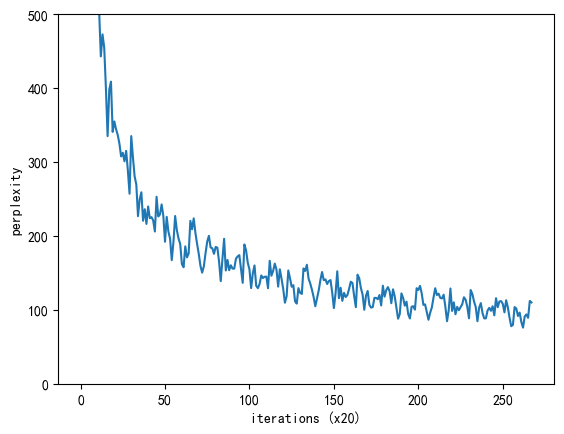

evaluating perplexity ...
234 / 235
test perplexity:  136.42147627671523


In [9]:
import sys
sys.path.append('..') # 为了导入上一级目录的common模块
from common.optimizer import SGD 
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from rnnlm import Rnnlm


# 设定超参数
batch_size = 20 # mini-batch的大小
wordvec_size = 100 # 词向量的维数
hidden_size = 100  # RNN的隐藏状态向量的元素个数
time_size = 35  # RNN的展开大小
lr = 20.0 # 学习率
max_epoch = 4 # 最大迭代轮数
max_grad = 0.25 # 用于梯度裁剪的阈值

# 读入训练数据
corpus, word_to_id, id_to_word = ptb.load_data('train') # 训练数据
corpus_test, _, _ = ptb.load_data('test') # 测试数据
vocab_size = len(word_to_id) # 词汇表大小
xs = corpus[:-1] # 输入数据
ts = corpus[1:] # 目标数据

# 生成模型
model = Rnnlm(vocab_size, wordvec_size, hidden_size) # RNN语言模型
optimizer = SGD(lr) # 随机梯度下降法
trainer = RnnlmTrainer(model, optimizer) # 训练器

# step1:应用梯度裁剪进行学习
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20) # 每20轮评估一次
trainer.plot(ylim=(0, 500)) # 绘制学习曲线

# step2:基于测试数据进行评价
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)

# step3:保存参数
model.save_params()

这里给出的代码和上一章的代码有很多相同的地方，因此这里重点介绍不同的地方。首先，代码 step1 处使用 `RnnlmTrainer` 类进行模型的学习。`RnnlmTrainer` 类的 `fit()` 方法求模型的梯度，更新模型的参数。另外，在方法内部，通过指定 `max_grad` 参数，从而应用梯度裁剪。顺便说一下，`fit()` 方法内部进行的实现如下所示（这里给出的是伪代码）。

```python
# 求梯度
model.forward(...)
model.backward(...)
params, grads = model.params, model.grads
# 梯度裁剪
if max_grad is not None:
    clip_grads(grads, max_grad)
# 更新参数
optimizer.update(params, grads)
```

我们在之前的小节将梯度裁剪实现为了 `clip_grads(grads, max_grad)`，这里使用该方法进行梯度裁剪。

另外，通过 step1 处的 `fit()` 方法的参数 `eval_interval=20`，每 20 次迭代对困惑度进行 1 次评价。因为这次的数据量很大，所以没有对每个 epoch 进行评价，而是每 20 次迭代评价 1 次。后面我们会将评价结果用 `plot()` 方法绘制成图。

在学习结束后，在代码 step2 处使用测试数据对困惑度进行评价。这里需要注意的是，此时需要先重置模型的状态（LSTM 的隐藏状态和记忆单元）。此外，因为评价困惑度的函数 `eval_perplexity()` 在 `common/util.py` 中已经实现，所以直接使用即可。

最后，在代码 step3 处将学习好的参数保存到外部文件。在下一章生成句子时，将会使用这些学习好的权重参数。

以上就是 RNNLM 的学习代码。执行代码后，在终端上会输出下图的结果。

<img src="./fig/output.png" alt="output" style="display: block; margin: 0 auto;">

在图中，每 20 次迭代输出 1 次困惑度的值。我们来看一下结果，刚开始的困惑度为 10 000.84，这意味着下一个单词的候选个数能减少到 10 000 个左右。因为这次数据集的词汇量是 10 000 个，所以这是什么也没学习的状态，相当于猜测。但是随着学习的进行，困惑度开始变好。实际上，当迭代超过 300 次时，困惑度已经降到了 400 以下。现在，我们看一下困惑度的演变图，如下图所示。

<img src="./fig/perplexity_change.png" alt="perplexity_change" style="display: block; margin: 0 auto;">

在这次的实验中，一共进行了 4 个 epoch 的学习（按迭代来算，相当于 1327 * 4 次）。如图所示，困惑度顺利下降，最终达到 100 左右。基于最终的测试数据的评价（源代码 step2 处）结果为 136.07…。该结果在每次执行时都不相同，但是都在 135 前后。换句话说，我们的模型成长到了能将下一个单词的候选个数（从 10 000 个）缩小到 136 个左右的水平。

那么，136 这样的困惑度在实践中是什么水平呢？说实话，这并不是一个很好的结果。在 2017 年的一个研究中，PTB 数据集上的困惑度已经降到了 60 以下。我们的模型还有很大的改进空间，下面我们就来进一步改进现有的 RNNLM。

## 进一步改进RNNLM
本节我们先针对当前的 RNNLM 说明 3 点需要改进的地方，然后实施这些改进，并评价最后精度提高了多少。

## LSTM层的多层化
在使用 RNNLM 创建高精度模型时，加深 LSTM 层（叠加多个 LSTM 层）的方法往往很有效。之前我们只用了一个 LSTM 层，通过叠加多个层，可以提高语言模型的精度。例如，在下图中，RNNLM 使用了两个 LSTM 层。

<img src="./fig/two_LSTM.png" alt="two_LSTM" style="display: block; margin: 0 auto;">

上图显示了叠加两个 LSTM 层的例子。此时，第一个 LSTM 层的隐藏状态是第二个 LSTM 层的输入。按照同样的方式，我们可以叠加多个 LSTM 层，从而学习更加复杂的模式，这和前馈神经网络时的层加深是一样的。在前作《深度学习入门：基于 Python 的理论与实现》中，我们通过叠加多个 Affine 层和 Convolution 层，创建了表现力更好的模型。

那么，应该叠加几个层呢？这其实是一个关于超参数的问题。因为层数是超参数，所以需要根据要解决的问题的复杂程度、能给到的训练数据的规模来确定。顺便说一句，在 PTB 数据集上学习语言模型的情况下，当 LSTM 的层数为 2 ~ 4 时，可以获得比较好的结果。

据报道，谷歌翻译中使用的 GNMT 模型是叠加了 8 层 LSTM 的网络。如该例所示，如果待解决的问题很难，又能准备大量的训练数据，就可以通过加深 LSTM 层来提高精度。

## 基于Dropout抑制过拟合
通过叠加 LSTM 层，可以期待能够学习到时序数据的复杂依赖关系。换句话说，通过加深层，可以创建表现力更强的模型，但是这样的模型往往会发生**过拟合**（overfitting）。更糟糕的是，RNN 比常规的前馈神经网络更容易发生过拟合，因此 RNN 的过拟合对策非常重要。

过拟合是指过度学习了训练数据的状态，也就是说，过拟合是一种缺乏泛化能力的状态。我们想要的是一个泛化能力强的模型，因此必须基于训练数据和验证数据的评价差异，判断是否发生了过拟合，并据此来进行模型的设计。

抑制过拟合已有既定的方法：一是增加训练数据；二是降低模型的复杂度。我们会优先考虑这两个方法。除此之外，对模型复杂度给予惩罚的**正则化**也很有效。比如，L2 正则化会对过大的权重进行惩罚。

此外，像 Dropout 这样，在训练时随机忽略层的一部分（比如 50%）神经元，也可以被视为一种正则化。本节我们将仔细研究 Dropout，并将其应用于 RNN。

<img src="./fig/dropout.png" alt="dropout" style="display: block; margin: 0 auto;">

如图所示，Dropout 随机选择一部分神经元，然后忽略它们，停止向前传递信号。这种 “随机忽视” 是一种制约，可以提高神经网络的泛化能力。我们在前作《深度学习入门：基于 Python 的理论与实现》中已经实现了 Dropout。如下图所示，当时我们给出了在激活函数后插入 Dropout 层的示例，并展示了它有助于抑制过拟合。

<img src="./fig/dropout_example.png" alt="dropout_example" style="display: block; margin: 0 auto;">

那么，在使用 RNN 的模型中，应该将 Dropout 层插入哪里呢？首先可以想到的是插入在 LSTM 层的时序方向上，如下图所示。不过答案是，这并不是一个好的插入方式。

<img src="./fig/dropout_bad_example.png" alt="dropout_bad_example" style="display: block; margin: 0 auto;">

如果在时序方向上插入 Dropout，那么当模型学习时，随着时间的推移，信息会渐渐丢失。也就是说，因 Dropout 产生的噪声会随时间成比例地积累。考虑到噪声的积累，最好不要在时间轴方向上插入 Dropout。因此，如下图所示，我们在深度方向（垂直方向）上插入 Dropout 层。

<img src="./fig/dropout_good_example.png" alt="dropout_good_example" style="display: block; margin: 0 auto;">

这样一来，无论沿时间方向（水平方向）前进多少，信息都不会丢失。Dropout 与时间轴独立，仅在深度方向（垂直方向）上起作用。

如前所述，“常规的 Dropout” 不适合用在时间方向上。但是，最近的研究提出了多种方法来实现时间方向上的 RNN 正则化。比如，有文献中提出的 “变分 Dropout”（variational dropout）就被成功地应用在了时间方向上。

除了深度方向，变分 Dropout 也能用在时间方向上，从而进一步提高语言模型的精度。如下图所示，它的机制是同一层的 Dropout 使用相同的 mask。这里所说的 mask 是指决定是否传递数据的随机布尔值。

<img src="./fig/dropout_mask.png" alt="dropout_mask" style="display: block; margin: 0 auto;">

如图所示，通过同一层的 Dropout 共用 mask，mask 被 “固定”。如此一来，信息的损失方式也被 “固定”，所以可以避免常规 Dropout 发生的指数级信息损失。

据说变分 Dropout 比常规 Dropout 的效果更好。不过，本章并不打算使用变分 Dropout，而是仍使用常规 Dropout。变分 Dropout 的想法很简单，感兴趣的读者可以自己尝试实现一下。

## 权重共享
改进语言模型有一个非常简单的技巧，那就是**权重共享**（weight tying）。weight tying 可以直译为 “权重绑定”。如下图所示，其含义就是共享权重。

<img src="./fig/weight_shared.png" alt="weight_shared" style="display: block; margin: 0 auto;">

如图所示，绑定（共享）Embedding 层和 Affine 层的权重的技巧在于权重共享。通过在这两个层之间共享权重，可以大大减少学习的参数数量。尽管如此，它仍能提高精度。真可谓一石二鸟！

现在，我们来考虑一下权重共享的实现。这里，假设词汇量为 $V$，LSTM 的隐藏状态的维数为 $H$，则 Embedding 层的权重形状为 $V \times H$，Affine 层的权重形状为 $H \times V$。此时，如果要使用权重共享，只需将 Embedding 层权重的转置设置为 Affine 层的权重。这个非常简单的技巧可以带来出色的结果。

为什么说权重共享是有效的呢？直观上，共享权重可以减少需要学习的参数数量，从而促进学习。另外，参数数量减少，还能收获抑制过拟合的好处。有论文从理论上描述了权重共享为什么有用，感兴趣的读者可以参考一下。

## 更好的RNNLM的实现
至此，我们介绍了 RNNLM 的 3 点有待改进的地方。接下来，我们来看一下这些技巧会在多大程度上有效。这里，将下图的层结构实现为 `BetterRnnlm` 类。

<img src="./fig/betterRNNLM.png" alt="betterRNNLM" style="display: block; margin: 0 auto;">

如图所示，改进的 3 点如下：
- LSTM 层的多层化（此处为 2 层）
- 使用 Dropout（仅应用在深度方向上）
- 权重共享（Embedding 层和 Affine 层的权重共享）

现在，我们来实现进行了这 3 点改进的 `BetterRnnlm` 类，如下所示。

In [10]:
import sys
sys.path.append('..') # 为了导入上一级目录的common模块
from common.time_layers import *
from common.np import *  # import numpy as np
from common.base_model import BaseModel


class BetterRnnlm(BaseModel):
    '''
     利用2个LSTM层并在各层使用Dropout的模型
     基于[1]提出的模型，利用weight tying[2][3]

     [1] Recurrent Neural Network Regularization (https://arxiv.org/abs/1409.2329)
     [2] Using the Output Embedding to Improve Language Models (https://arxiv.org/abs/1608.05859)
     [3] Tying Word Vectors and Word Classifiers (https://arxiv.org/pdf/1611.01462.pdf)
    '''
    def __init__(self, vocab_size=10000, wordvec_size=650,
                 hidden_size=650, dropout_ratio=0.5): 
        V, D, H = vocab_size, wordvec_size, hidden_size # 词汇表大小、词向量维数、隐藏状态向量维数
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f') # 词向量矩阵
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f') # 第1个LSTM层的输入到隐藏层的权重
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f') # 第1个LSTM层的隐藏层到隐藏层的权重
        lstm_b1 = np.zeros(4 * H).astype('f') # 第1个LSTM层的偏置
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f') # 第2个LSTM层的输入到隐藏层的权重
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f') # 第2个LSTM层的隐藏层到隐藏层的权重
        lstm_b2 = np.zeros(4 * H).astype('f') # 第2个LSTM层的偏置
        affine_b = np.zeros(V).astype('f') # 输出层的偏置

        self.layers = [
            TimeEmbedding(embed_W), # 词嵌入层
            TimeDropout(dropout_ratio), # Dropout层
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True), # 第1个LSTM层
            TimeDropout(dropout_ratio), # Dropout层
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True), # 第2个LSTM层
            TimeDropout(dropout_ratio), # Dropout层
            TimeAffine(embed_W.T, affine_b)  # 输出层，权重参数采用weight tying[2][3]
        ]
        self.loss_layer = TimeSoftmaxWithLoss() # 损失函数层
        self.lstm_layers = [self.layers[2], self.layers[4]] # 方便后面重置状态
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]] # 方便设置训练标志

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs, train_flg=False): # train_flg用于区分训练和测试，train_flg=True表示训练
        for layer in self.drop_layers:
            layer.train_flg = train_flg # 设置训练标志

        for layer in self.layers:
            xs = layer.forward(xs) # 前向传播
        return xs

    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg) # 预测值
        loss = self.loss_layer.forward(score, ts) # 计算损失
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout) # 损失层的反向传播
        for layer in reversed(self.layers): # 反向传播
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state() # 重置LSTM的状态

layer层的代码就是刚才所说的改进的地方，具体而言，叠加两个 `Time LSTM` 层，使用 `Time Dropout` 层，并在 `Time Embedding` 层和 `Time Affine` 层之间共享权重。

下面进行改进过的 `BetterRnnlm` 类的学习。在这之前，我们稍微改动一下将要执行的学习代码。这个改动是，针对每个 epoch 使用验证数据评价困惑度，在值变差时，降低学习率。这是一种在实践中经常用到的技巧，并且往往能有好的结果。这里的实现参考了 PyTorch 的语言模型的实现示例，学习代码如下所示。

In [ ]:
import sys
sys.path.append('..')
from common import config
# 在用GPU运行时，请打开下面的注释（需要cupy）
# ==============================================
# config.GPU = True
# ==============================================
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity, to_gpu
from dataset import ptb
from better_rnnlm import BetterRnnlm


# 设定超参数
batch_size = 20 # mini-batch的大小
wordvec_size = 650 # 词向量的维数
hidden_size = 650 # 隐藏层的维数
time_size = 35 # RNN展开的时间步数
lr = 20.0 # 学习率
max_epoch = 40 # 最大迭代轮数
max_grad = 0.25 # 用于梯度裁剪的阈值
dropout = 0.5 # Dropout的比例

# 读入训练数据
corpus, word_to_id, id_to_word = ptb.load_data('train') # 训练数据
corpus_val, _, _ = ptb.load_data('val') # 验证数据
corpus_test, _, _ = ptb.load_data('test') # 测试数据

if config.GPU:
    corpus = to_gpu(corpus)
    corpus_val = to_gpu(corpus_val)
    corpus_test = to_gpu(corpus_test)

vocab_size = len(word_to_id) # 词汇表大小
xs = corpus[:-1] # 输入数据
ts = corpus[1:] # 目标数据

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout) # RNN语言模型
optimizer = SGD(lr) # 随机梯度下降法
trainer = RnnlmTrainer(model, optimizer) # 训练器

best_ppl = float('inf') # 最佳困惑度
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state() # 在评估困惑度之前需要重置状态
    ppl = eval_perplexity(model, corpus_val) # 计算验证数据的困惑度
    print('验证数据的困惑度: ', ppl)  # 输出验证数据的困惑度

    # 根据困惑度调整学习率
    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state() # 重置状态
    print('-' * 50)


# 基于验证数据进行评价
model.reset_state() # 重置状态
ppl_test = eval_perplexity(model, corpus_test) # 计算测试数据的困惑度
print('测试数据的困惑度: ', ppl_test)

这里针对每个 epoch 使用验证数据评价困惑度，当它比之前的困惑度（`best_ppl`）低时，将学习率乘以 1/4。为此，我们用 `for` 循环反复执行以下处理：通过 `RnnlmTrainer` 类的 `fit()` 方法进行一个 epoch 的学习，然后使用验证数据评价困惑度。现在让我们运行一下学习代码。

这个学习需要相当长的时间。在用 CPU 运行的情况下，需要 2 天左右；而如果用 GPU 运行，则能在 5 小时左右完成（在用 GPU 运行时，需要去掉文件顶部 import 语句中的 # config.GPU = True 这行注释）。

执行上面的代码，困惑度平稳下降，最终在测试数据上获得了困惑度为 75.76 的结果（每次运行结果不同）。考虑到改进前的 RNNLM 的困惑度约为 136，这个结果可以说提升很大。通过 LSTM 的多层化提高表现力，通过 Dropout 提高泛化能力，通过权重共享有效利用权重，从而实现了精度的大幅提高。

## 前沿研究
至此，我们对 RNNLM 的改进就结束了。通过对 RNNLM 进行若干改造，精度显著提升，在 PTB 数据集的测试数据上达到了 75 左右的困惑度，可以说是一个还算不错的结果。不过，前沿研究走得更远。这里我想简单地介绍一下最新的研究结果，让我们来看一下下图。

<img src="./fig/result_ptb.png" alt="result_ptb" style="display: block; margin: 0 auto;">

上图摘自文献，该表总结了过去各个阶段最优语言模型在 PTB 数据集上的困惑度结果。由 Test 列可知，随着新方法被提出，困惑度在下降，最后一行的结果是 52.8。实际上，这个 52.8 是一个非常好的结果。在 PTB 数据集上的困惑度接近 50，这在几年前还是无法想象的。

这里只展示了最先进的研究结果。当然，我们的模型和它还有相当的距离，但是图中的最先进的模型和我们的模型有很多共同点。比如，最先进的模型使用了多层 LSTM 模型，并进行了基于 Dropout 的正则化（变分 Dropout 和 DropConnect）和权重共享。在此基础上，它进一步使用了最优化和正则化的几个技巧，并严格进行了超参数的调整，最终达成了 52.8 这样惊人的值。

图中有一个名为AWD-LSTM 3-layer LSTM (tied) + continuous cache pointer的模型。这个continuous cache pointer技术基于第8章会详细介绍的 Attention。Attention是一项非常重要的技术，被应用在许多地方。在语言模型这个任务中，它也为精度提高做出了重大贡献。让我们期待第8章的 Attention。


## 小结 
- 在简单 RNN 的学习中，存在梯度消失和梯度爆炸问题
- 梯度裁剪对解决梯度爆炸有效，LSTM、GRU 等 Gated RNN 对解决梯度消失有效
- LSTM 中有 3 个门：输入门、遗忘门和输出门
- 门有专门的权重，并使用 sigmoid 函数输出 0.0 ～ 1.0 的实数
- LSTM 的多层化、Dropout 和权重共享等技巧可以有效改进语言模型
- RNN 的正则化很重要，人们提出了各种基于 Dropout 的方法